In [1]:
import numpy as np
import torch
import collections
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from hGLM_class import hGLM
from sklearn import metrics

# Hyperparams

In [2]:
train_T = 20000
test_T = 8000
N = 629 + 120
B = 101

batch_size = 8192

synlocs = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/synlocs_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.npy")
G = torch.zeros(synlocs.shape[0])
for i in range(G.shape[0]):
    loc = synlocs[i,1]
    if loc < 1/3:
        G[i] = 0
    elif loc == 1.5:
        G[i] = 6
    elif (loc >= 1/3) & (loc < 2/3):
        G[i] = 1
    elif (loc >= 2/3) & (loc < 1):
        G[i] = 2
    elif (loc >= 1) & (loc < 4/3):
        G[i] = 3
    elif (loc >= 4/3) & (loc < 5/3):
        G[i] = 4
    elif (loc >= 5/3) & (loc < 2):
        G[i] = 5
G_no = int(torch.max(G).item()) + 1

zero_idx = np.where(synlocs[:,1] == 1)
print(zero_idx)
C_den = torch.tensor([0,1,1,1,1])

M = C_den.shape[0]
print(M)

(array([630, 631, 632, 633, 635, 637, 638, 639, 641, 642, 643, 645, 646,
       647, 649, 650, 651, 652, 653, 654, 655, 656, 658, 659, 660, 661,
       662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 674, 675,
       676, 677, 678, 679, 680, 681, 682, 683, 684, 686, 687, 688, 689,
       690, 691, 693, 694, 695, 696, 697, 698, 700, 701, 702, 704, 705,
       706, 707, 708, 709, 710, 711, 713, 714, 715, 716, 717, 718, 719,
       720, 721, 722, 723, 724, 725, 726, 727, 728, 730, 731, 732, 733,
       734, 735, 736, 737, 738, 739, 741, 742, 744, 745, 746, 747, 748]),)
5


In [3]:
C_syn = torch.zeros(M, N)
#Ensyn = torch.tensor([0, 97, 222, 180, 130])
#Insyn = torch.tensor([1,21, 36, 36 ,26])
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])

count = 0
for m in range(M):
    for e in range(Ensyn[m]):
        C_syn[m,count] = 1
        count += 1
        
for m in range(M):
    for i in range(Insyn[m]):
        C_syn[m,count] = -1
        count += 1
        


# Init/Save

In [4]:
np.save("/media/hdd01/sklee/hglm/biophysical/final_fit/C_den.npy", C_den.cpu().detach().numpy())
np.save("/media/hdd01/sklee/hglm/biophysical/final_fit/C_syn.npy", C_syn.cpu().detach().numpy())

# Adjust W and C

In [4]:
C_den = np.load("/media/hdd01/sklee/hglm/biophysical/final_fit/C_den.npy")
C_syn = np.load("/media/hdd01/sklee/hglm/biophysical/final_fit/C_syn.npy")

E_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")[:train_T]
I_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")[:train_T]
neural = np.hstack((E_neural, I_neural))

Delta_init = np.exp(4.3201)
W_init = np.asarray([ 0.0542,  0.0542,  0.0542, -0.0208, -0.0208, -0.0208, -0.0099])
Tau_init = np.exp(np.asarray([1.6063, 1.6063, 1.6063, 1.9158, 1.9158, 1.9158, 1.8307]))
Theta_init = 2.1128
sigma_init = 0.125
#C_init = np.exp(3.2998)
C_init = 5
#C_init = 0.3

new_Theta = np.empty((M))
new_C = np.ones((M))
#new_W = np.empty((G_no))

window = np.arange(B) - Delta_init
window = np.heaviside(window, 0)
filt_neural = np.empty((neural.shape[0], neural.shape[1]))
### filt_neural includes both synaptic kernel and W multiplied!

In [5]:
for g in range(G_no):
    g_idx = torch.where(G == g)[0].numpy()
    in_g = neural[:,g_idx]
    out_g = np.empty((in_g.shape[0], in_g.shape[1]))
    
    if g < G_no//2:
        t_tau_g_fast = window / Tau_init[g]
        t_tau_g_slow = window / (Tau_init[g] * 2.8 + 10.4)
        kern_g_fast = np.multiply(t_tau_g_fast, np.exp(-t_tau_g_fast))
        kern_g_slow = np.multiply(t_tau_g_slow, np.exp(-t_tau_g_slow)) * 0.3
        kern_g = (kern_g_slow + kern_g_fast)/1.3
    else:
        t_tau_g = window / Tau_init[g]
        kern_g = np.multiply(t_tau_g, np.exp(-t_tau_g))
        
    for i in range(in_g.shape[1]):
        out_g[:,i] = np.convolve(in_g[:,i], kern_g, mode="same")
    
    filt_neural[:, g_idx] = out_g * W_init[g]

In [6]:
upstream_out = np.empty((filt_neural.shape[0], M))
##### upstream_out contains subunit outputs after nonlin, before C

for i in range(C_syn.shape[0]): ### loop through subunits
    subunit = C_den.shape[0] - 1 - i
    
    upstream_idx = np.where(C_den == subunit+1)[0]
    if upstream_idx.size == 0:
        upstream_in = np.zeros((filt_neural.shape[0], ))
    else:
        upstream_in = np.sum(upstream_out[:,upstream_idx], axis=1)
    
    e_idx = np.where(C_syn[subunit] == 1)[0].reshape((1,-1))
    i_idx = np.where(C_syn[subunit] == -1)[0].reshape((1,-1))
    sub_idx = np.sort(np.hstack((e_idx, i_idx)).flatten())
    sub_neural = filt_neural[:,sub_idx]
    sub_in = np.sum(sub_neural, axis=1)
    mean_sub_in = np.mean(sub_in)
    
    old_sigma = np.std(sub_in + upstream_in * C_init)
    sigma_factor = sigma_init / old_sigma
    
    ######
    ######
    
    if upstream_idx.size > 0:
        new_C[upstream_idx] = C_init * sigma_factor
    
    comb_in = sub_in + upstream_in*C_init*sigma_factor
    new_Theta[subunit] = np.mean(comb_in)
    comb_out = 1 / (1+np.exp(-1 * comb_in + new_Theta[subunit]))
    upstream_out[:,subunit] = comb_out
    

In [7]:
print(new_C)
print(new_Theta)
print(np.mean(upstream_out, axis=0))
print(np.std(upstream_out, axis=0))

[1.        2.4263367 2.4263367 2.4263367 2.4263367]
[4.555883   0.09420077 0.21839702 0.18442149 0.07309924]
[0.49996517 0.49998573 0.49997118 0.4999389  0.49998928]
[0.02968626 0.01963471 0.02659801 0.02867368 0.01648109]


In [8]:
np.save("/media/hdd01/sklee/hglm/biophysical/final_fit/adjusted_W.npy", W_init)
np.save("/media/hdd01/sklee/hglm/biophysical/final_fit/adjusted_C.npy", np.log(new_C))
np.save("/media/hdd01/sklee/hglm/biophysical/final_fit/adjusted_Theta.npy", new_Theta)
np.save("/media/hdd01/sklee/hglm/biophysical/final_fit/adjusted_Tau.npy", np.log(Tau_init))
np.save("/media/hdd01/sklee/hglm/biophysical/final_fit/adjusted_Delta.npy", np.log(Delta_init))


# Train ALL Params

In [4]:
C_den = np.load("/media/hdd01/sklee/hglm/biophysical/final_fit/C_den.npy")
C_syn = np.load("/media/hdd01/sklee/hglm/biophysical/final_fit/C_syn.npy")
C_den = torch.from_numpy(C_den)
C_syn = torch.from_numpy(C_syn)

test_V_ref = np.load("/media/hdd01/sklee/hglm/biophysical/test_V_ref.npy")[:]
test_V_ref = torch.from_numpy(test_V_ref).cuda()

train_V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")[1:-2][:train_T]
train_V_ref = torch.from_numpy(train_V_ref)

In [5]:
E_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

train_neural = np.hstack((E_neural, I_neural))[:train_T]
test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
train_neural = torch.from_numpy(train_neural)
test_neural = torch.from_numpy(test_neural).cuda()


In [6]:
adjust_W = np.load("/media/hdd01/sklee/hglm/biophysical/final_fit/adjusted_W.npy")
adjust_C = np.load("/media/hdd01/sklee/hglm/biophysical/final_fit/adjusted_C.npy")
adjust_Theta = np.load("/media/hdd01/sklee/hglm/biophysical/final_fit/adjusted_Theta.npy")
adjust_Tau = np.load("/media/hdd01/sklee/hglm/biophysical/final_fit/adjusted_Tau.npy")
adjust_Delta = np.load("/media/hdd01/sklee/hglm/biophysical/final_fit/adjusted_Delta.npy")

adjust_W = torch.from_numpy(adjust_W)
adjust_C = torch.from_numpy(adjust_C)
adjust_Theta = torch.from_numpy(adjust_Theta)
adjust_Tau = torch.from_numpy(adjust_Tau)
adjust_Delta = torch.from_numpy(adjust_Delta).reshape(1)

print(adjust_W)
print(adjust_C)
print(adjust_Theta)
print(adjust_Tau)
print(adjust_Delta)

tensor([ 0.0542,  0.0542,  0.0542, -0.0208, -0.0208, -0.0208, -0.0099],
       dtype=torch.float64)
tensor([0.0000, 0.8864, 0.8864, 0.8864, 0.8864], dtype=torch.float64)
tensor([4.5559, 0.0942, 0.2184, 0.1844, 0.0731], dtype=torch.float64)
tensor([1.6063, 1.6063, 1.6063, 1.9158, 1.9158, 1.9158, 1.8307],
       dtype=torch.float64)
tensor([4.3201], dtype=torch.float64)


In [7]:
fit_hGLM = hGLM(C_den, C_syn, B, G, Ensyn)

with torch.no_grad():
    fit_hGLM.W = nn.Parameter(adjust_W)
    fit_hGLM.C = nn.Parameter(adjust_C)
    fit_hGLM.Tau = nn.Parameter(adjust_Tau)
    fit_hGLM.Theta = nn.Parameter(adjust_Theta)
    fit_hGLM.Delta = nn.Parameter(adjust_Delta)
    
fit_hGLM.train().float().cuda()

hGLM()

In [8]:
repeat_no = 2
batch_no = (train_V_ref.shape[0]) * 2
train_idx = np.empty((repeat_no, train_V_ref.shape[0]))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0])
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)

40000


In [9]:
fit_hGLM.Theta.requires_grad = True
fit_hGLM.W.requires_grad = True
fit_hGLM.Delta.requires_grad = True
fit_hGLM.V_o.requires_grad = True
fit_hGLM.C.requires_grad= True
fit_hGLM.Tau.requires_grad= True


In [10]:
optimizer = optim.Adam(fit_hGLM.parameters(), lr=0.001)
#optimizer = optim.SGD(fit_hGLM.parameters(), lr=0.0005)

In [11]:
loss_array = np.empty((batch_no))

for i in tnrange(batch_no):
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_X = train_neural[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred = fit_hGLM(batch_X)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()

    diff = (batch_ref - batch_pred) ** 1
    loss = torch.var(diff)
    
    loss.backward()
    optimizer.step()
    
    #if fit_hGLM.W.grad[1,1] != 0:
        #print(i, fit_hGLM.W.grad)
    
    if i%100 == 0:
        test_pred = fit_hGLM(test_neural.float())
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print(i, test_loss.item(), test_score, train_score)
        if i%500 == 0:
            torch.save(fit_hGLM.state_dict(), "/media/hdd01/sklee/hglm/biophysical/final_fit/final5_hglm_i"+str(i)+".pt")
    


<ipython-input-11-cdafa481d543>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


0 13.613217061999844 0.014342853753432583 0.007966686925923616
100 13.357747391379315 0.032839988227453376 0.025567015374842406
200 13.036912947752738 0.05606982149367956 0.04842347037184136
300 12.604580953744257 0.08737257075514027 0.06863508476829516
400 12.15117892890709 0.12020088345717894 0.10456522981924132
500 11.418107250466877 0.1732785164330798 0.17062922579616568
600 10.735239187933129 0.2227211854647424 0.1147523355632355



KeyboardInterrupt: 

# Continue Training

In [4]:
C_den = np.load("/media/hdd01/sklee/hglm/biophysical/final_fit/C_den.npy")
C_syn = np.load("/media/hdd01/sklee/hglm/biophysical/final_fit/C_syn.npy")
C_den = torch.from_numpy(C_den)
C_syn = torch.from_numpy(C_syn)

test_V_ref = np.load("/media/hdd01/sklee/hglm/biophysical/test_V_ref.npy")[:]
test_V_ref = torch.from_numpy(test_V_ref).cuda()

train_V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")[1:-2][:train_T]
train_V_ref = torch.from_numpy(train_V_ref)

In [5]:
E_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

train_neural = np.hstack((E_neural, I_neural))[:train_T]
test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
train_neural = torch.from_numpy(train_neural)
test_neural = torch.from_numpy(test_neural).cuda()


In [6]:
fit_hGLM = hGLM(C_den, C_syn, B, G, Ensyn)
fit_hGLM.load_state_dict(torch.load("/media/hdd01/sklee/hglm/biophysical/final_fit/final4_hglm_i12000.pt"))
start_i = 12000
fit_hGLM.train().float().cuda()

hGLM()

In [7]:
repeat_no = 2
batch_no = (train_V_ref.shape[0]) * 2
train_idx = np.empty((repeat_no, train_V_ref.shape[0]))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0])
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)

40000


In [8]:
#optimizer = optim.SGD(fit_hGLM.parameters(), lr=0.000002)
optimizer = optim.Adam(fit_hGLM.parameters(), lr=0.001)

In [9]:
loss_array = np.empty((batch_no))

for i in tnrange(batch_no):
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_X = train_neural[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred = fit_hGLM(batch_X)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()

    diff = (batch_ref - batch_pred) ** 1
    loss = torch.var(diff)
    
    loss.backward()
    optimizer.step()
    
    #if fit_hGLM.W.grad[1,1] != 0:
        #print(i, fit_hGLM.W.grad)
    
    if i%100 == 0:
        test_pred = fit_hGLM(test_neural.float())
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print(i+start_i, test_loss.item(), test_score, train_score)
        torch.save(fit_hGLM.state_dict(), "/media/hdd01/sklee/hglm/biophysical/final_fit/final4_hglm_i"+str(i+start_i)+".pt")
    


<ipython-input-9-cf78f2a98269>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


12000 2.9661660092101387 0.7852364575509845 0.7148272717962927
12100 2.764160315786148 0.7998625634764255 0.7659141559904722
12200 2.783311085972108 0.7984759630061893 0.6897316045711234
12300 2.8537475899947817 0.7933760484775082 0.709685127502877
12400 2.755344176683004 0.8005008909080695 0.7353047614327105
12500 2.7526910148634207 0.8006929916088221 0.7584454602317441
12600 2.793639686514696 0.7977281266324093 0.6856072093075546
12700 2.8249794232500167 0.7954589910455804 0.7119624041425052
12800 2.8214952675653877 0.7957112593301281 0.7646438165263171
12900 2.795578214405162 0.7975877686357047 0.7762028766895305
13000 3.0089805303051342 0.7821364968071853 0.62628449373956
13100 2.76505288098086 0.7997979378174945 0.7651342086106183
13200 2.767185914449565 0.7996434967481032 0.6931745133113605
13300 2.828603537114283 0.7951965891309176 0.6679334060294998
13400 2.774943429909251 0.7990818183303887 0.7755015907146854
13500 2.7667674293889357 0.7996737969346217 0.7623387671390528
13600

KeyboardInterrupt: 

In [10]:
print(list(fit_hGLM.parameters()))

[Parameter containing:
tensor([-68.8529], device='cuda:0', requires_grad=True), Parameter containing:
tensor([1.0415, 1.1518, 1.3475, 2.6747, 2.2815, 2.3802, 2.8664],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([2.5948], device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.0463,  0.0467,  0.0403, -0.0106, -0.0414, -0.0180, -0.0188],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([3.2171, 2.3481, 2.3688, 2.2894, 2.1348], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([18.2334,  0.0808,  0.5655,  0.1198,  0.1533], device='cuda:0',
       requires_grad=True)]


In [10]:
print(list(fit_hGLM.parameters()))

[Parameter containing:
tensor([-68.7257], device='cuda:0', requires_grad=True), Parameter containing:
tensor([1.2150, 0.7612, 1.7563, 2.7970, 2.4131, 2.4347, 2.9189],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([2.5111], device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.0850,  0.1193,  0.0713, -0.0221, -0.1033, -0.0333, -0.0150],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([3.3524, 1.4805, 1.5589, 1.4853, 1.4110], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([5.8997, 0.7093, 1.3444, 0.5424, 1.1404], device='cuda:0',
       requires_grad=True)]


0.8931642188344856


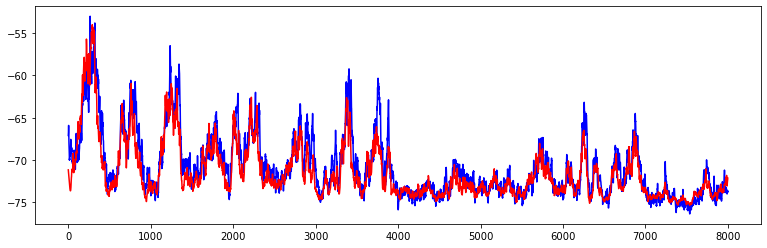

In [18]:
plt.figure(figsize = (13, 4))
plt.plot(test_V_ref.cpu().detach().numpy()[:], c="blue")
plt.plot(test_pred.cpu().detach().numpy()[:]-8.2, c="red")
print(np.corrcoef(test_V_ref[:].cpu().detach().numpy(),
                  test_pred[:].cpu().detach().numpy())[0][1])

# Test

In [4]:
C_den = np.load("/media/hdd01/sklee/hglm/biophysical/final_fit/C_den.npy")
C_syn = np.load("/media/hdd01/sklee/hglm/biophysical/final_fit/C_syn.npy")
C_den = torch.from_numpy(C_den)
C_syn = torch.from_numpy(C_syn)

final_hGLM = hGLM(C_den, C_syn, B, G, Ensyn)
final_hGLM.load_state_dict(torch.load("/media/hdd01/sklee/hglm/biophysical/final_fit/final5_hglm_i12500.pt"))
final_hGLM.eval().cuda()

test_V_ref = np.load("/media/hdd01/sklee/hglm/biophysical/test_V_ref.npy")


In [5]:
E_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")
test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
test_neural = torch.from_numpy(test_neural).cuda()

test_V_final = final_hGLM(test_neural.float()).cpu().detach().numpy()

0.8961038502935589


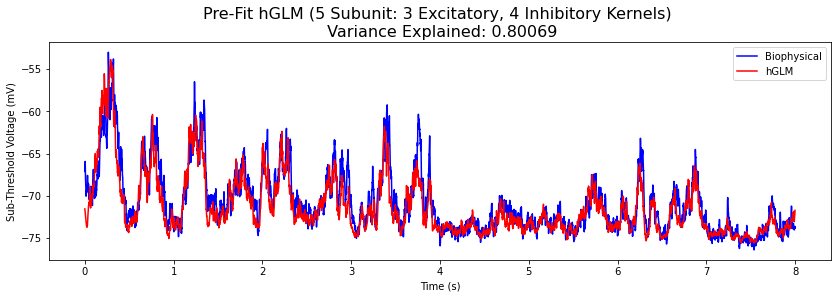

In [14]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref, label="Biophysical", c="blue")
plt.plot(test_V_final-8.9, label="hGLM", c="red")
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref,
                                                      y_pred=test_V_final,
                                                      multioutput='uniform_average')

plt.title("Pre-Fit hGLM (5 Subunit: 3 Excitatory, 4 Inhibitory Kernels) \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


plt.savefig("/media/hdd01/sklee/hglm/biophysical/final5_fit_test.png", dpi=150, bbox_inches='tight')